# Derivations
Specifically of discretizing and linearizing continuous time dynamics as well as quadraticizing costs.

References:
1. [Jackson, Howell - iLQR Tutorial](http://roboticexplorationlab.org/papers/iLQR_Tutorial.pdf)
1. [Kavuncu et. al. - Potential iLQR](https://arxiv.org/pdf/2107.04926.pdf)
1. [Pyomo - 2.6 Model Predictive Control of a Double Integrator](https://jckantor.github.io/ND-Pyomo-Cookbook/02.06-Model-Predictive-Control-of-a-Double-Integrator.html)
1. [Discretizing an SSM](https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models)
1. [Drake - ilqr_driving](https://colab.research.google.com/github/RussTedrake/underactuated/blob/master/exercises/trajopt/ilqr_driving/ilqr_driving.ipynb#scrollTo=WCdJhqQqHLii)
1. [Al - Augmenting an Angular State](https://github.com/anassinator/ilqr/blob/master/ilqr/examples/cartpole.py)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from sympy.utilities.codegen import codegen
from IPython.display import display, Math

In [3]:
%matplotlib ipympl
np.set_printoptions(precision=3, suppress=True)

## Dynamical System [1]
A dynamical system can be modeled by the following non-linear, continuous dynamics:

$$\dot x = f_c(x, u)$$

Discretizing using the [following method](https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models):

$$x_{k+1} = f(x_k, u_k)$$

Using a 1st order Taylor Series expansion, we linearize around an operating point:

$$\begin{aligned}
x_{k+1} + \delta x_{k+1} &\approx f(x_k, u_k) + 
\left.\frac{\partial f}{\partial x}\right|_{x_k, u_k}(x - x_k) + 
\left.\frac{\partial f}{\partial u}\right|_{x_k, u_k}(u - u_k)
\\
\delta x_{k+1} &= A \delta x_k + B \delta u_k
\end{aligned}
$$

In [4]:
def discretize(A, B, Δt):
    """Compute the discretization of continuous dynamics assuming zero-order hold."""
    
    k, t = sym.symbols('k t')
    Ad = sym.exp(A * Δt).simplify()
    # Ad_approx = sym.summation(1/sym.factorial(k) * (A*Δt) ** k, (k, 0, sym.oo))
    Ad_approx = sym.eye(A.shape[0], A.shape[0]) + A * Δt
    # Bd = A**-1 * (Ad - sym.eye(4,4)) * B # for non-singular A
    Bd = sym.integrate(Ad, (t, 0, Δt)) * B
    
    return Ad, Bd

In [5]:
def linearize(x_dot, x, u):
    """Compute the linearization of the dynamics with respect to x and u."""
    
    A = x_dot.jacobian(x)
    B = x_dot.jacobian(u)
    return A, B

## Unicycle Dynamics [2]
A unicycle can be modelled using the following continuous dynamics:

$$\begin{aligned}
x &= \begin{bmatrix} p_x & p_y & v & \theta \end{bmatrix} \\
u &= \begin{bmatrix} a & \omega\end{bmatrix}
\end{aligned}$$


$$\begin{aligned}
\dot p_{x} &= v\cos\theta \\
\dot p_{y} &= v\sin\theta \\
\dot \theta &= \omega \\
\dot v &= a
\end{aligned}$$

In [6]:
Δt = sym.Symbol('\Delta t')
p_x, p_y, v, theta, omega, a = sym.symbols('p_x p_y v theta omega a')

x = sym.Matrix([p_x, p_y, v, theta])
u = sym.Matrix([a, omega])
display(Math('x = ' + sym.latex(x) + 'u = ' + sym.latex(u)))

<IPython.core.display.Math object>

In [7]:
x_dot = sym.Matrix([
    x[2]*sym.cos(x[3]),
    x[2]*sym.sin(x[3]),
    u[0],
    u[1],
])

A, B = linearize(x_dot, x, u)
print('Continuous Time:')
display(Math('A = ' + sym.latex(A) + '\; B = ' + sym.latex(B)))

Ad, Bd = discretize(A, B, Δt)
print('Discrete Time:')
display(Math('A_d = ' + sym.latex(Ad)))
display(Math('B_d = \Delta t ' + sym.latex(Bd/Δt)))

print('Others:')
Bo = sym.Matrix([[0, 0], [0, 0], [Δt, 0], [0, Δt]])
display(Math('B = \Delta t' + sym.latex(Bo/Δt)))

Continuous Time:


<IPython.core.display.Math object>

Discrete Time:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Others:


<IPython.core.display.Math object>

## Car Dynamics
- "car" dynamics represent a simplified version of the unicycle dynamics where the linear velocity is in the control, rather than the state.
$$\begin{aligned}
x &= \begin{bmatrix} p_x & p_y & \theta \end{bmatrix} \\
u &= \begin{bmatrix} v & \omega\end{bmatrix}
\end{aligned}$$


$$\begin{aligned}
\dot p_{x} &= v\cos\theta \\
\dot p_{y} &= v\sin\theta \\
\dot \theta &= \omega \\
\end{aligned}$$

In [8]:
delta_t = sym.Symbol('\Delta t')
p_x, p_y, v, theta, omega = sym.symbols('p_x p_y v theta omega')

x = sym.Matrix([p_x, p_y, theta])
u = sym.Matrix([v, omega])
display(Math('x = ' + sym.latex(x)))
display(Math('u = ' + sym.latex(u)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
x_dot = sym.Matrix([
    u[0]*sym.cos(x[2]),
    u[0]*sym.sin(x[2]),
    u[1],
])

A, B = linearize(x_dot, x, u)
print('Continuous time:')
display(Math('A = ' + sym.latex(A) + '\;B = ' + sym.latex(B)))

Ad, Bd = discretize(A, B, Δt)
print('Discrete Time:')
display(Math('A_d = ' + sym.latex(Ad) + '\;B_d = \Delta t ' + sym.latex(Bd/Δt)))

Continuous time:


<IPython.core.display.Math object>

Discrete Time:


<IPython.core.display.Math object>

## Bicycle Dynamics [5]
- We can add an additional component to the standard car/unicycle dynamics via steering.
- Letting $\phi$ be the steering angle, the dynamics are:
$$\begin{aligned}
x &= \begin{bmatrix} p_x & p_y & v & \theta & \phi \end{bmatrix} \\
u &= \begin{bmatrix} a & \rho\end{bmatrix}
\end{aligned}$$


$$\begin{aligned}
\dot p_{x} &= v\cos\theta \\
\dot p_{y} &= v\sin\theta \\
\dot v &= a \\
\dot \phi &= \rho \\
\end{aligned}$$

In [10]:
delta_t = sym.Symbol('\Delta t')
p_x, p_y, theta, v, phi, a, rho = sym.symbols('p_x p_y theta v phi a rho')

x = sym.Matrix([p_x, p_y, v, theta, phi])
u = sym.Matrix([a, rho])
display(Math('x = ' + sym.latex(x) + '\;u = ' + sym.latex(u)))

<IPython.core.display.Math object>

In [11]:
x_dot = sym.Matrix([
    x[2]*sym.cos(x[3]),
    x[2]*sym.sin(x[3]),
    u[0],
    x[2]*sym.tan(x[4]),
    u[1]
])

A, B = linearize(x_dot, x, u)
print('Continuous time:')
display(Math('A = ' + sym.latex(A) + '\;B = ' + sym.latex(B)))

Ad, Bd = discretize(A, B, Δt)
print('Discrete Time:')
display(Math('A_d = ' + sym.latex(Ad)))
display(Math('B_d = \Delta t ' + sym.latex(Bd/Δt)))

Continuous time:


<IPython.core.display.Math object>

Discrete Time:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
Bd.simplify()
Bd / Δt

Matrix([
[\Delta t*(-\Delta t*v*sin(theta)*tan(phi)/2 + cos(theta)), -\Delta t**2*v**2*sin(theta)/(2*cos(phi)**2)],
[ \Delta t*(\Delta t*v*cos(theta)*tan(phi)/2 + sin(theta)),  \Delta t**2*v**2*cos(theta)/(2*cos(phi)**2)],
[                                                        1,                                            0],
[                                        \Delta t*tan(phi),                       \Delta t*v/cos(phi)**2],
[                                                        0,                                            1]])

## Double Integrator Dynamics [3]
- The double integrator model is a canonical second order linear system often used to demostrate control principles. 
- This can be represented in the discretized equation as:
$$x_{k+1} = A x_k + B u_k 
= \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix} x_k + \begin{bmatrix} \frac{\Delta t^2}{2} \\ \Delta t \end{bmatrix} u_k$$

In [13]:
# dt = sym.Symbol('\Delta t')
dt, p_x, p_y, v_x, v_y, a_x, a_y = sym.symbols('dt p_x p_y v_x v_y a_x a_y')

x = sym.Matrix([p_x, p_y, v_x, v_y])
u = sym.Matrix([a_x, a_y])
display(Math('x = ' + sym.latex(x) + '\;u = ' + sym.latex(u)))

<IPython.core.display.Math object>

In [14]:
x_dot = sym.Matrix([
    v_x,
    v_y,
    a_x,
    a_y
])

A = x_dot.jacobian(x)
B = x_dot.jacobian(u)
x_dot

Matrix([
[v_x],
[v_y],
[a_x],
[a_y]])

## Quadcopter Dynamics (6D)

In [16]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols("o_x, o_y, o_z")

# pitch, and roll angles (radians)
theta, phi = sym.symbols("theta, phi")

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols("v_x, v_y, v_z")

# net rotor force
tau = sym.symbols("tau")

In [17]:
x = sym.Matrix([o_x, o_y, o_z, v_x, v_y, v_z])
u = sym.Matrix([tau, phi, theta])

g = sym.nsimplify(9.81)

In [18]:
# Full EOM: (the full EOM is a nonlinear function of [states, inputs, and fixed
# parameters])
x_dot = sym.Matrix(
    [v_x, v_y, v_z, g * sym.tan(theta), -g * sym.tan(phi), tau - g]
)

A = x_dot.jacobian(x)  # here the state vector is 6-dimensional
B = x_dot.jacobian(u)  # here the input vector is also 6-dimensional

## Quadcopter Dynamics (12D)

In [89]:
# # components of position (meters)
o_x, o_y, o_z = sym.symbols("o_x, o_y, o_z")

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols("psi, theta, phi")

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols("v_x, v_y, v_z")

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols("w_x, w_y, w_z")

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols("tau_x, tau_y, tau_z")

# net rotor force
f_z = sym.symbols("f_z")

In [90]:
x = sym.Matrix(
    [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
)  # state variables
u = sym.Matrix([tau_x, tau_y, tau_z, f_z])  # input variables

In [91]:
m = sym.nsimplify(0.0315)  # mass of a Crazyflie drone

# Principle moments of inertia of a Crazyflie drone
J_x = sym.nsimplify(1.7572149113694408e-05)
J_y = sym.nsimplify(1.856979710568617e-05)
J_z = sym.nsimplify(2.7159794713754086e-05)

# Acceleration of gravity
g = 9.81

# Linear and angular velocity vectors (in body frame)
v_01in1 = sym.Matrix([[v_x], [v_y], [v_z]])
w_01in1 = sym.Matrix([[w_x], [w_y], [w_z]])

# Create moment of inertia matrix (in coordinates of the body frame).
J_in1 = sym.diag(J_x, J_y, J_z)

# Z-Y-X rotation sequence
Rz = sym.Matrix(
    [
        [sym.cos(psi), -sym.sin(psi), 0],
        [sym.sin(psi), sym.cos(psi), 0],
        [0, 0, 1],
    ]
)

Ry = sym.Matrix(
    [
        [sym.cos(theta), 0, sym.sin(theta)],
        [0, 1, 0],
        [-sym.sin(theta), 0, sym.cos(theta)],
    ]
)

Rx = sym.Matrix(
    [
        [1, 0, 0],
        [0, sym.cos(phi), -sym.sin(phi)],
        [0, sym.sin(phi), sym.cos(phi)],
    ]
)

R_1in0 = Rz * Ry * Rx

# Mapping from angular velocity to angular rates
# Compute the invserse of the mapping first:
Ninv = sym.Matrix.hstack(
    (Ry * Rx).T * sym.Matrix([[0], [0], [1]]),
    (Rx).T * sym.Matrix([[0], [1], [0]]),
    sym.Matrix([[1], [0], [0]]),
)
N = sym.simplify(Ninv.inv())  # this matrix N is what we actually want

# forces in world frame
f_in1 = R_1in0.T * sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix(
    [[0], [0], [f_z]]
)

# torques in world frame
tau_in1 = sym.Matrix([[tau_x], [tau_y], [tau_z]])

In [91]:
# Full EOM:
f_sym = sym.Matrix.vstack(
    R_1in0 * v_01in1,
    N * w_01in1,
    (1 / m) * (f_in1 - w_01in1.cross(m * v_01in1)),
    J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1)),
)

A = f_sym.jacobian(x)  # here the state vector is 12-dimensional
B = f_sym.jacobian(u)  # here the input vector is 6-dimensional

## Augmented Unicycle Dynamics [2]
A unicycle can be modelled using the following augmented continuous dynamics:

$$\begin{aligned}
x &= \begin{bmatrix} p_x & p_y & v & \sin(\theta) & \cos(\theta) \end{bmatrix} \\
u &= \begin{bmatrix} a & \omega\end{bmatrix}
\end{aligned}$$


$$\begin{aligned}
\dot p_{x} &= v\cos\theta \\
\dot p_{y} &= v\sin\theta \\
\dot \theta &= \omega \\
\dot v &= a
\end{aligned}$$

In [20]:
Δt = sym.Symbol('\Delta t')
sθ = sym.Symbol('\sin \Theta')
cθ = sym.Symbol('\cos \Theta')
p_x, p_y, v, omega, a = sym.symbols('p_x p_y v omega a')

x = sym.Matrix([p_x, p_y, v, sθ, cθ])
u = sym.Matrix([a, omega])
display(Math('x = ' + sym.latex(x) + '\;u = ' + sym.latex(u)))

<IPython.core.display.Math object>

In [21]:
x_dot = sym.Matrix([
    x[2]*x[4],
    x[2]*x[3],
    u[0],
    u[1]*x[4], # sym.sin(u[1]),
    -u[1]*x[3] # sym.cos(u[1])
])

A, B = linearize(x_dot, x, u)
print('Continuous Time:')
display(Math('A = ' + sym.latex(A) + '\;B = ' + sym.latex(B)))

Ad, Bd = discretize(A, B, Δt)
print('Discrete Time:')
display(Math('A_d = ' + sym.latex(Ad) + '\;B_d = \Delta t ' + sym.latex(Bd/Δt)))

print('Others:')
Bo = sym.Matrix([[0, 0], [0, 0], [Δt, 0], [0, Δt]])
display(Math('B = \Delta t' + sym.latex(Bo/Δt)))

Continuous Time:


<IPython.core.display.Math object>

Discrete Time:


<IPython.core.display.Math object>

Others:


<IPython.core.display.Math object>

## Quadraticizing Costs

In [22]:
def quadraticize(L, x, u):
    """Quadraticize the costs with respect to the states and controls."""
    
    L_x = L.jacobian(x)
    L_u = L.jacobian(u)
    L_xx = L_x.jacobian(x)
    L_uu = L_u.jacobian(u)
    L_xu = L_x.jacobian(u)
    L_ux = L_u.jacobian(x)
    
    return L_x, L_u, L_xx, L_uu, L_xu, L_ux

In [23]:
def quadraticize_reference(x, u, x_r, Q, R, terminal=False):
    """Quadraticize reference costs analytically."""
    
    L_x = (x - x_r).T @ (Q + Q.T)
    L_u = u.T @ (R + R.T)
    L_xx = Q + Q.T
    L_uu = R + R.T
    L_xu = sym.zeros(x.shape[0], u.shape[0])
    L_ux = L_xu.T
    
    if terminal:
        γ = sym.symbols('gamma')
        L_x *= γ
        L_xx *= γ
        L_u = sym.zeros(1, u.shape[0])
        L_uu = sym.zeros(u.shape[0])
    
    return L_x, L_u, L_xx, L_uu, L_xu, L_ux

In [24]:
delta_t = sym.Symbol('\Delta t')
p_x, p_y, v, theta, omega, a = sym.symbols('p_x p_y v theta omega a')
p_xr, p_yr, v_r, theta_r, omega_r, a_r = sym.symbols('p_xr p_yr v_r theta_r omega_r a_r')
p_xo, p_yo = sym.symbols('p_xo p_yo')

x = sym.Matrix([p_x, p_y, v, theta])
u = sym.Matrix([omega, a])
x_r = sym.Matrix([p_xr, p_yr, v_r, theta_r])
x_o = sym.Matrix([p_xo, p_yo, 0, 0])

In [25]:
nx, nu = 4, 2
x = sym.MatrixSymbol('x', nx, 1)
u = sym.MatrixSymbol('u', nu, 1)
Q = sym.MatrixSymbol('Q', nx, nx)
R = sym.MatrixSymbol('R', nu, nu)

L = x.T @ Q @ x + u.T @ R @ u
Lx = L.diff(x)
Lu = L.diff(u)
Lxx = Lx.diff(x)
Luu = Lu.diff(u)
Lux = Lu.diff(x)

In [26]:
Q = sym.eye(x.shape[0])
R = sym.eye(u.shape[0])
# Q = sym.Matrix(np.arange(16)).reshape(4,4)
# Q = sym.diag(1, 1, 0, 0)
# Q[0,-1] = 1.0
# R = sym.diag(2.0, 1.0)
# R[0,-1] = 3.0

display(Math('Q = ' + sym.latex(Q)))
display(Math('R = ' + sym.latex(R)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [27]:
L.jacobian(x).jacobian(x)

AttributeError: 'MatAdd' object has no attribute 'jacobian'

In [28]:
L = (x - x_r).T @ Q @ (x - x_r) + (u.T @ R @ u)
L_x, L_u, L_xx, L_uu, L_xu, L_ux = quadraticize(L, x, u)
L_x_a, L_u_a, L_xx_a, L_uu_a, L_xu_a, L_ux_a = quadraticize_reference(x, u, x_r, Q, R)

display(Math('L_u = ' + sym.latex(L_u) + ' = u^T (R + R^T) = ' + sym.latex(L_u_a)))
display(Math('L_x = ' + sym.latex(L_x) + ' = (x - x_r)^T (Q + Q^T)'))
display(Math('L_{xx} = ' + sym.latex(L_xx) + ' = Q + Q^T = ' + sym.latex(L_xx_a)))
display(Math('L_{uu} = ' + sym.latex(L_uu) + ' = R + R^T = ' + sym.latex(L_uu_a)))
display(Math('L_{xu} = L_{ux}^T = ' + sym.latex(L_xu_a)))

AttributeError: 'MatAdd' object has no attribute 'jacobian'

In [29]:
dL_dxu = L_x.row_join(L_u) # Gradient
dL_dxu

NameError: name 'L_x' is not defined

In [154]:
dL2_dxu2 = sym.Matrix(sym.BlockMatrix([
    [L_xx, L_xu],
    [L_xu.T, L_uu]
])) # Hessian
dL2_dxu2

Matrix([
[2, 0, 0, 0, 0, 0],
[0, 2, 0, 0, 0, 0],
[0, 0, 2, 0, 0, 0],
[0, 0, 0, 2, 0, 0],
[0, 0, 0, 0, 2, 0],
[0, 0, 0, 0, 0, 2]])

In [14]:
γ = sym.symbols('gamma')
L_N = γ * (x - x_r).T @ Q @ (x - x_r)
L_x, L_u, L_xx, L_uu, L_xu, L_ux = quadraticize(L_N, x, u)
L_x_a, L_u_a, L_xx_a, L_uu_a, L_xu_a, L_ux_a = quadraticize_reference(x, u, x_r, Q, R, terminal=True)

display(Math('L_u = ' + sym.latex(L_u) + ' = u^T (R + R^T) = ' + sym.latex(L_u_a)))
display(Math('L_x = ' + sym.latex(L_x.T) + ' = (x - x_r)^T (Q + Q^T) = ' + sym.latex(L_x_a.T)))
display(Math('L_{xx} = ' + sym.latex(L_xx) + ' = Q + Q^T = ' + sym.latex(L_xx_a)))
display(Math('L_{uu} = ' + sym.latex(L_uu) + ' = R + R^T = ' + sym.latex(L_uu_a)))
display(Math('L_{xu} = L_{ux}^T = ' + sym.latex(L_xu_a)))

AttributeError: 'MatMul' object has no attribute 'jacobian'

### Obstacle Cost
$$L = \min(0, d-d_{max})^2$$

In [30]:
from sympy.functions.elementary.piecewise import Piecewise
import matplotlib.pyplot as plt

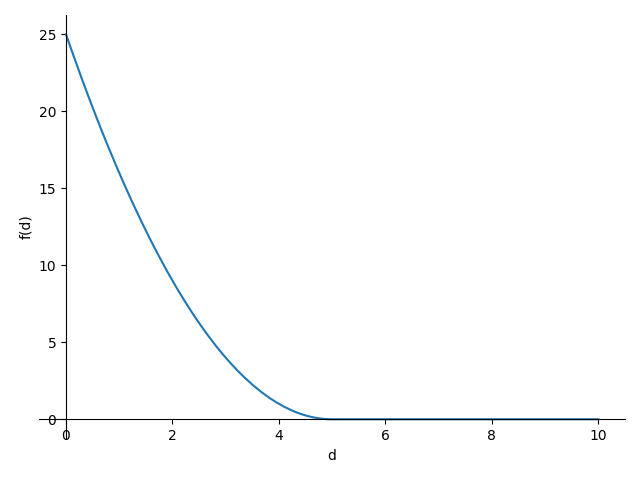

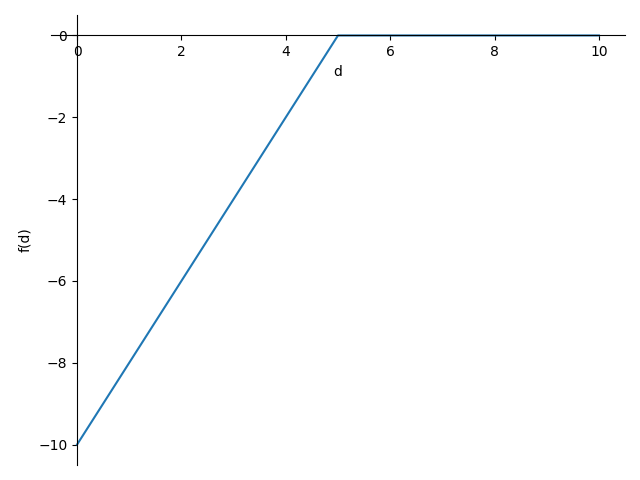

Text(0.5, 1.0, 'Lx')

In [31]:
d_max, d = sym.symbols('d_{max} d', positive=True)
L = Piecewise((0, d > d_max), ((d - d_max)**2, d <= d_max))

sym.plot(L.subs(d_max, 5), (d, 0, 10))
plt.title('L')
sym.plot(L.subs(d_max, 5).diff(d), (d, 0, 10))
plt.title('Lx')

In [82]:
a_x, a_y, a_z, b_x, b_y, b_z = sym.symbols('a_x a_y a_z b_x b_y b_z')
x = sym.Matrix([a_x, a_y, a_z, v, theta, b_x, b_y, b_z, theta])
d = sym.sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2)
L = sym.Matrix([(d - d_max)**2])

x2 = sym.Matrix([a_x, a_y, v, theta, b_x, b_y, theta])
d2 = sym.sqrt((a_x - b_x)**2 + (a_y - b_y)**2)
L2 = sym.Matrix([(d2 - d_max)**2])

L

Matrix([[(-d_{max} + sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2))**2]])

In [83]:
L_x, _, L_xx, *_ = quadraticize(L, x, u)
L_x2, _, L_xx2, *_ = quadraticize(L2, x, u)
L_x.simplify()
L_x

Matrix([[-2*(a_x - b_x)*(d_{max} - sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2), -2*(a_y - b_y)*(d_{max} - sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2), -2*(a_z - b_z)*(d_{max} - sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2), 0, 0, 2*(a_x - b_x)*(d_{max} - sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2), 2*(a_y - b_y)*(d_{max} - sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2), 2*(a_z - b_z)*(d_{max} - sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2))/sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2), 0]])

In [88]:
L_xx.subs({"a_x": 0.1, "a_y": 0., "a_z": 0.5, "b_x": 1, "b_y": 0.4, "b_z": 0.3, d_max: 2.0})

Matrix([
[  1.21185173052674,   1.41866688505187, -0.709333442525933, 0, 0,  -1.21185173052674,  -1.41866688505187,  0.709333442525933, 0],
[  1.41866688505187,  -1.34963014526135, -0.315259307789304, 0, 0,  -1.41866688505187,   1.34963014526135,  0.315259307789304, 0],
[-0.709333442525933, -0.315259307789304,  -1.82251910694531, 0, 0,  0.709333442525933,  0.315259307789304,   1.82251910694531, 0],
[                 0,                  0,                  0, 0, 0,                  0,                  0,                  0, 0],
[                 0,                  0,                  0, 0, 0,                  0,                  0,                  0, 0],
[ -1.21185173052674,  -1.41866688505187,  0.709333442525933, 0, 0,   1.21185173052674,   1.41866688505187, -0.709333442525933, 0],
[ -1.41866688505187,   1.34963014526135,  0.315259307789304, 0, 0,   1.41866688505187,  -1.34963014526135, -0.315259307789304, 0],
[ 0.709333442525933,  0.315259307789304,   1.82251910694531, 0, 0, -0.7093

In [51]:
L_xx.simplify()
L_xx

Matrix([
[ 2*d_{max}*(a_x - b_x)**2/((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2)**(3/2) - 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2) + 2,         2*d_{max}*(a_x*a_y - a_x*b_y - a_y*b_x + b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + a_z**2 - 2*a_z*b_z + b_x**2 + b_y**2 + b_z**2)**(3/2),         2*d_{max}*(a_x*a_z - a_x*b_z - a_z*b_x + b_x*b_z)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + a_z**2 - 2*a_z*b_z + b_x**2 + b_y**2 + b_z**2)**(3/2), 0, 0, -2*d_{max}*(a_x - b_x)**2/((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2)**(3/2) + 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_y)**2 + (a_z - b_z)**2) - 2,        2*d_{max}*(-a_x*a_y + a_x*b_y + a_y*b_x - b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + a_z**2 - 2*a_z*b_z + b_x**2 + b_y**2 + b_z**2)**(3/2),        2*d_{max}*(-a_x*a_z + a_x*b_z + a_z*b_x - b_x*b_z)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + a_z**2 - 2*a_z*b_z + b_x**2 + b_y**2 + b_z**2)**(3/2), 0],
[        2*d_{max}*(a_x*a_y - a_x*b_y - a_y*

In [78]:
L_xx[2, 0].factor()

2*d_{max}*(a_x - b_x)*(a_z - b_z)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + a_z**2 - 2*a_z*b_z + b_x**2 + b_y**2 + b_z**2)**(3/2)

In [67]:
L_xx2[1, 0].factor()

2*d_{max}*(a_x - b_x)*(a_y - b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + b_x**2 + b_y**2)**(3/2)

In [52]:
L_xx2.simplify()
L_xx2

Matrix([
[ 2*d_{max}*(a_x - b_x)**2/((a_x - b_x)**2 + (a_y - b_y)**2)**(3/2) - 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_y)**2) + 2,     2*d_{max}*(a_x*a_y - a_x*b_y - a_y*b_x + b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + b_x**2 + b_y**2)**(3/2), 0, 0, 0, -2*d_{max}*(a_x - b_x)**2/((a_x - b_x)**2 + (a_y - b_y)**2)**(3/2) + 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_y)**2) - 2,    2*d_{max}*(-a_x*a_y + a_x*b_y + a_y*b_x - b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + b_x**2 + b_y**2)**(3/2), 0, 0],
[    2*d_{max}*(a_x*a_y - a_x*b_y - a_y*b_x + b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + b_x**2 + b_y**2)**(3/2),  2*d_{max}*(a_y - b_y)**2/((a_x - b_x)**2 + (a_y - b_y)**2)**(3/2) - 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_y)**2) + 2, 0, 0, 0,    2*d_{max}*(-a_x*a_y + a_x*b_y + a_y*b_x - b_x*b_y)/(a_x**2 - 2*a_x*b_x + a_y**2 - 2*a_y*b_y + b_x**2 + b_y**2)**(3/2), -2*d_{max}*(a_y - b_y)**2/((a_x - b_x)**2 + (a_y - b_y)**2)**(3/2) + 2*d_{max}/sqrt((a_x - b_x)**2 + (a_y - b_

### Obstacle Cost 2

Same as before with linear cost from $d_{max}$ to $2 d_{max}$.

In [66]:
d_max, d, gamma = sym.symbols('d_{max} d gamma', positive=True)
L = Piecewise(
    ((d - d_max)**2 + gamma, d <= d_max),
    (gamma * (2 - d/d_max), (d_max <= d) & (d <= 2 * d_max)),
    (0,  d > 2*d_max)
)

Ls = L.subs({d_max: 5, gamma: 10})

sym.plot(Ls, (d, 0, 10))
plt.title('L')
sym.plot(Ls.diff(d), (d, 0, 10))
plt.title('Lx')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Lx')